# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 04 : Analyse multivariée - Interactions et structures cachées

---

### Identité du document

* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 31 Décembre 2025
* **Dernière mise à jour :** 02 Janvier 2026
* **Dépendances notebooks :** Notebooks 0, 1, 2, 3

### Description

Ce notebook est dédié à une **analyse multivariée** visant à dépasser les relations bivariées simples pour explorer la **complexité réelle** des émissions de GES.
Il adopte une posture plus **exploratoire et créative** : formuler des hypothèses métier, tester des interactions, identifier des structures latentes (segments/archétypes), et évaluer la possibilité de réduire la dimensionnalité sans perdre l’essentiel de l’information.

### Objectifs principaux

1. **Visualiser** les relations multiples simultanément (vue globale multivariée).
2. **Tester** des hypothèses d’**interactions** (effets synergiques entre variables) et sélectionner celles qui apportent un gain.
3. **Analyser** les effets **conditionnels** (une relation peut changer selon le contexte : type, quartier, époque).
4. **Identifier** des **archétypes** de bâtiments via clustering (groupes naturels aux profils d’émissions distincts).
5. **Réduire** la dimensionnalité via PCA pour comprendre la structure globale (variance expliquée, composantes).
6. **Structurer** un **blueprint de feature engineering** priorisé pour la phase de modélisation.

### Dépendances critiques

* `hydra` : Gestion de configuration (chemins, variables, paramètres d’analyse).
* `pandas`, `numpy` : Manipulation et préparation des données.
* `seaborn`, `matplotlib` : Visualisations multivariées (pairplot, FacetGrid, distributions).
* `scikit-learn` : `StandardScaler`, `KMeans`, `PCA`, métriques (silhouette), pipeline éventuel.
* `src/features/` : Fonctions pour création et traçabilité des nouvelles variables.
* `src/viz/` (optionnel) : Fonctions utilitaires de visualisation reproductible.

### LIVRABLES

1. **Notebook complété** : `notebooks/04_multivariate_full_analysis.ipynb`
2. **Interactions validées** : `reports/notebook_1/Validated_Interactions.csv`
3. **Profils de clusters** : `reports/notebook_1/Cluster_Profiles.md` (description narrative des archétypes)
4. **Blueprint Feature Engineering** : `reports/notebook_1/Feature_Engineering_Blueprint.md` (priorités + justifications)
5. **Rapport PCA** : `reports/notebook_1/PCA_Analysis.md` (variance expliquée + interprétation des composantes)
6. **Figures d’analyse** (≈ 15–20) : pairplot, facetgrids, clusters (PCA 2D), screeplot, biplot, scatter des interactions

---

# Table des Matières

* [Section 1 : Vue multivariée globale](#section-1--vue-multivariée-globale)
* [Section 2 : Hypothèses d'interactions et tests](#section-2--hypothèses-dinteractions-et-tests)
* [Section 3 : Analyse conditionnelle — Effets contextuels](#section-3--analyse-conditionnelle--effets-contextuels)
* [Section 4 : Clustering exploratoire](#section-4--clustering-exploratoire)
* [Section 5 : Réduction dimensionnelle — PCA (Principal Component Analysis)](#section-5--réduction-dimensionnelle--pca-principal-component-analysis)
* [Section 6 : Blueprint de Feature Engineering](#section-6--blueprint-de-feature-engineering)

---


# Section 1 : Vue multivariée globale

## Importation des bibliothèques nécessaires

In [3]:
pip install hydra-core==1.3.2 omegaconf pandas requests seaborn matplotlib scikit-learn numpy


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## loading des données 

In [2]:
import sys, logging
from pathlib import Path

# Pour que les imports
PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger
from data.load_data import load_data_raw

# Chargement et logging
cfg = load_config()                
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)
create_directories(cfg)             

# Chargement des données brutes
df_raw = load_data_raw(cfg)
df_raw.head()

2026-01-04 19:27:26,210 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\raw
2026-01-04 19:27:26,217 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\interim
2026-01-04 19:27:26,220 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\processed
2026-01-04 19:27:26,221 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\figures
2026-01-04 19:27:26,224 - utils.config_loader - INFO - Répertoire prêt : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\reports
2026-01-04 19:27:26,414 - data.load_data - INFO - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-04 19:27:26,510 - data.load_data - INFO -  Intégrité des données validée (Aucune modification détectée).


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


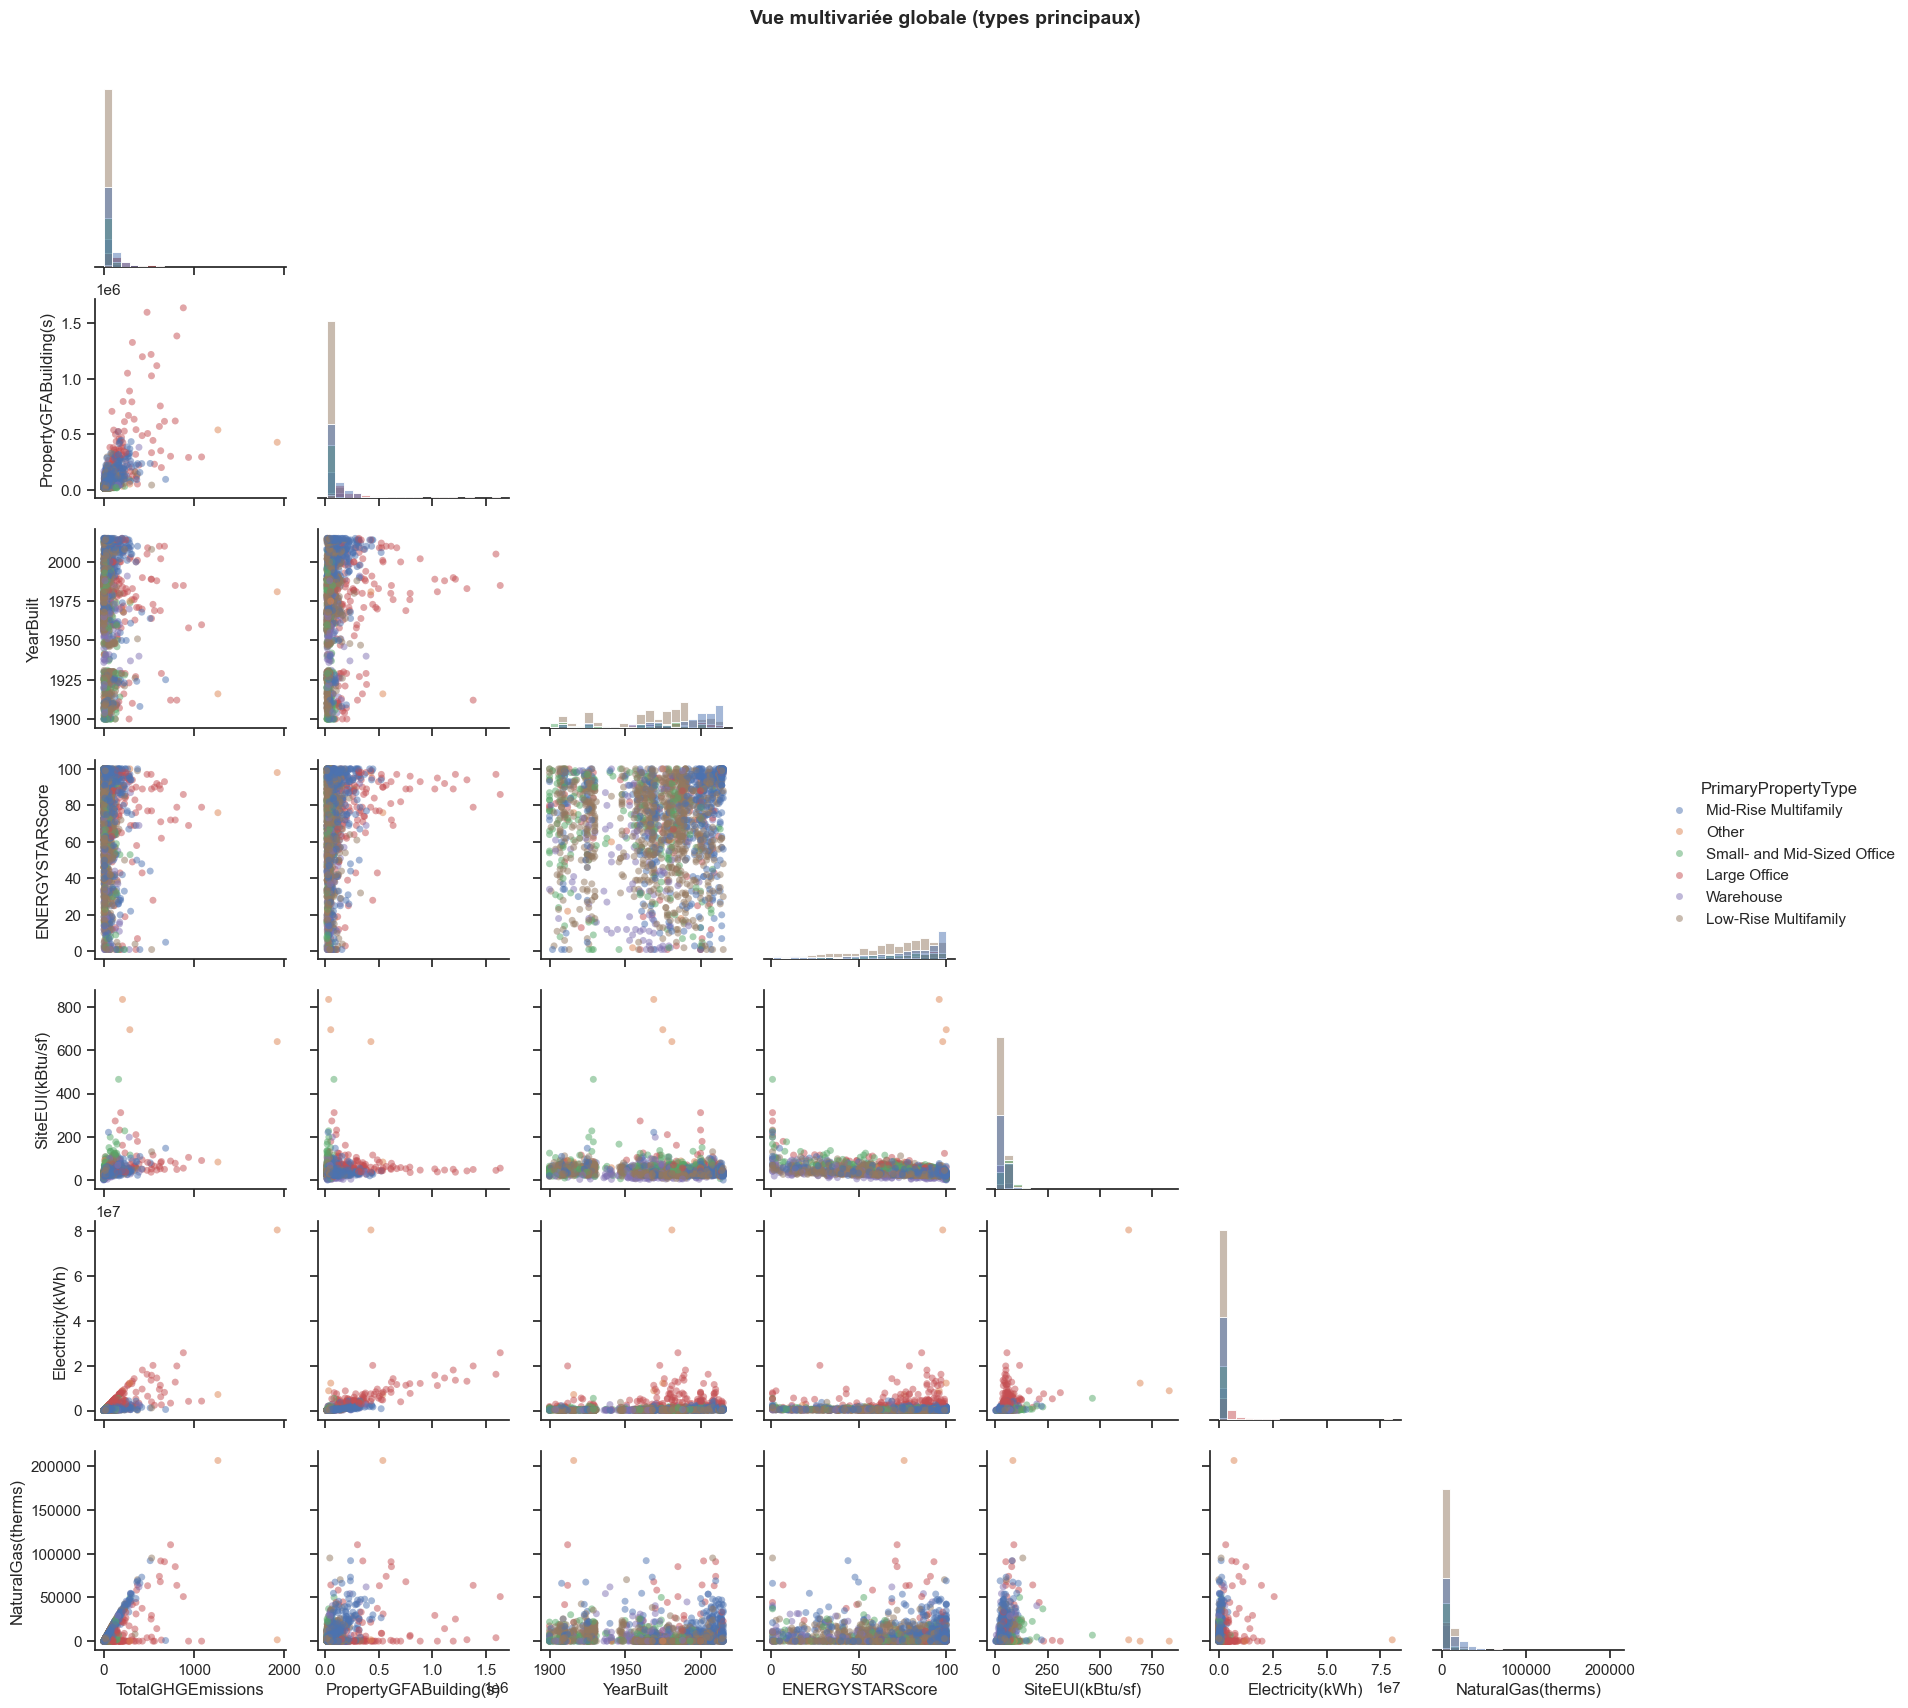

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables à tracer
cols_num = [
    "TotalGHGEmissions",
    "PropertyGFABuilding(s)",
    "YearBuilt",
    "ENERGYSTARScore",
    "SiteEUI(kBtu/sf)",
    "Electricity(kWh)",
    "NaturalGas(therms)",
]

hue_col = "PrimaryPropertyType"

# Sous-échantillon des catégories les plus fréquentes pour garder de la lisibilité
top_k = 6
top_types = (
    df_raw[hue_col]
    .value_counts()
    .head(top_k)
    .index
)

df_plot = (
    df_raw[df_raw[hue_col].isin(top_types)]
    .dropna(subset=cols_num + [hue_col])
)

sns.set_theme(style="ticks")
pair = sns.pairplot(
    df_plot,
    vars=cols_num,
    hue=hue_col,
    diag_kind="hist",
    corner=True,           # diagonale inférieure uniquement
    plot_kws={"alpha": 0.5, "s": 25, "edgecolor": "none"},
    diag_kws={"bins": 20, "edgecolor": "white"},
    height=2.4
)
pair.fig.suptitle("Vue multivariée globale (types principaux)", y=1.02, fontsize=14, weight="bold")
plt.show()


### Impact de la taille et des typologies

On observe une corrélation positive entre la surface (PropertyGFABuilding) et les émissions, avec une sensibilité à l'échelle plus marquée pour les bureaux que pour le résidentiel. Visuellement, une hiérarchie claire se dessine : les entrepôts et le résidentiel de faible hauteur occupent la zone de faibles émissions, tandis que les grands complexes de bureaux dominent le haut de la distribution.

### Profil de consommation énergétique

La nature de l'énergie influence la prévisibilité des résultats : la relation avec l'électricité est quasi linéaire (facteur d'émission stable), alors que celle avec le gaz naturel est plus diffuse. Les bureaux se distinguent par une double dominance dans la consommation de ces deux vecteurs énergétiques.

### Performance et efficacité énergétique

L'analyse des indicateurs révèle des comportements hétérogènes :

- Efficacité : Malgré une forte dispersion, les scores ENERGY STAR élevés sont associés à des consommations réduites dans certains segments de bureaux.

- Intensité (Site EUI) : On note une hétéroscédasticité marquée, la variance des émissions s'accroissant avec l'intensité énergétique, surtout pour les bureaux.

- Âge : Ce n'est pas un prédicteur linéaire simple, bien que les constructions post-1980 présentent un regroupement plus net que les bâtiments d'avant 1950.

### Propriétés statistiques et distribution

La structure des données est marquée par une forte asymétrie à droite pour la surface, l'énergie et les émissions, indiquant une minorité de très grands émetteurs. Des masses de probabilité (valeurs nulles en énergie) et des traces verticales (valeurs discrètes du score ENERGY STAR) caractérisent également les distributions.

# Section 2 : Hypothèses d'interactions et tests

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df_raw.copy()

# 1) Variables dérivées
df["Age"] = 2016 - df["YearBuilt"]
df["Interaction_Size_Intensity"] = df["PropertyGFABuilding(s)"] * df["SiteEUI(kBtu/sf)"]
df["Interaction_Age_ENERGY"] = df["Age"] * df["ENERGYSTARScore"]
df["Energy_Mix_Product"] = df["Electricity(kWh)"] * df["NaturalGas(therms)"]
df["Gas_Electricity_Ratio"] = df["NaturalGas(therms)"] / (df["Electricity(kWh)"] + 1)
df["Footprint_per_Floor"] = df["PropertyGFABuilding(s)"] / df["NumberofFloors"].replace(0, np.nan)
df["Age_x_Size"] = df["Age"] * df["PropertyGFABuilding(s)"]

# 2) Tableau de corrélations avec la cible
features_to_test = [
    # Individuelles
    "PropertyGFABuilding(s)",
    "SiteEUI(kBtu/sf)",
    "YearBuilt",
    "ENERGYSTARScore",
    "Electricity(kWh)",
    "NaturalGas(therms)",
    "NumberofFloors",
    "Age",
    # Interactions
    "Interaction_Size_Intensity",
    "Interaction_Age_ENERGY",
    "Energy_Mix_Product",
    "Gas_Electricity_Ratio",
    "Footprint_per_Floor",
    "Age_x_Size",
]
corr_rows = []
target = "TotalGHGEmissions"
for f in features_to_test:
    s = df[[target, f]].dropna()
    corr_rows.append({"feature": f, "pearson_with_GHG": s[target].corr(s[f])})
corr_df = pd.DataFrame(corr_rows).sort_values(by="pearson_with_GHG", key=lambda x: x.abs(), ascending=False)
corr_df


,feature,pearson_with_GHG
8,Interaction_Size_Intensity,0.746071
5,NaturalGas(therms),0.732294
4,Electricity(kWh),0.691111
10,Energy_Mix_Product,0.666378
0,PropertyGFABuilding(s),0.545503
13,Age_x_Size,0.439878
12,Footprint_per_Floor,0.288600
1,SiteEUI(kBtu/sf),0.286608
6,NumberofFloors,0.136014
3,ENERGYSTARScore,-0.101633


- Interaction Size × Intensity (0.75) ressort nettement au-dessus des variables seules : elle renforce l’effet combiné de la surface et de l’intensité énergétique. Hypothèse confirmée : l’impact de l’EUI est amplifié dans les grands bâtiments, interaction prometteuse.

- NaturalGas (0.73) et Electricity (0.69) gardent des corrélations fortes individuellement ; leur produit Energy_Mix_Product (0.67) apporte un gain vs chacun séparément, signe que le mix (avoir les deux postes élevés) discrimine encore mieux les fortes émissions.

- PropertyGFABuilding(s) seule (0.55) est moins informative que Size×Intensity : la taille brute explique, mais l’intensité pèse davantage quand combinée.
Age_x_Size (0.44) ajoute un signal par rapport à Age quasi nul : l’âge seul n’explique rien, mais l’âge des grands bâtiments augmente l’explication.

- Footprint_per_Floor (0.29) et SiteEUI (0.29) apportent un signal modéré ; l’empreinte par étage semble jouer, mais loin derrière les mixes d’énergie et la taille×intensité.
ENERGYSTARScore (-0.10) et Interaction_Age_ENERGY (-0.05) ne montrent pas d’effet linéaire simple sur GHG : l’hypothèse “score plus efficace pour les vieux bâtiments” n’apparaît pas en corrélation Pearson brute.

- Ratio gaz/électricité (~0.02) et âge/yearbuilt (~0) sont non informatifs en corrélation linéaire ; privilégier les interactions énergétiques plutôt que ces ratios simples.

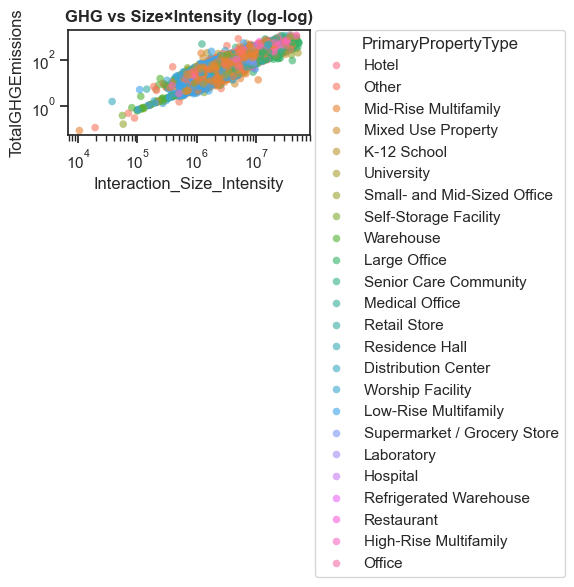

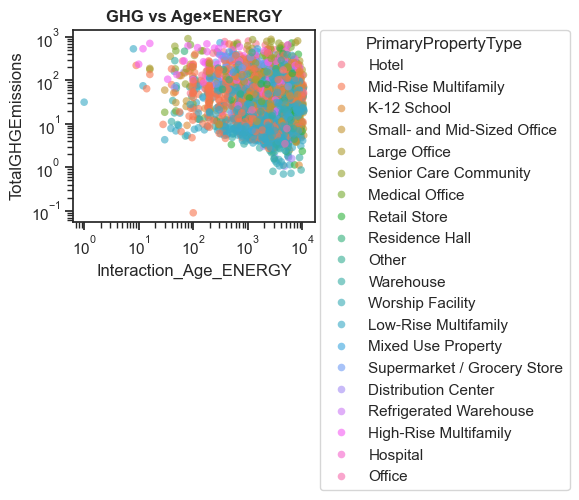

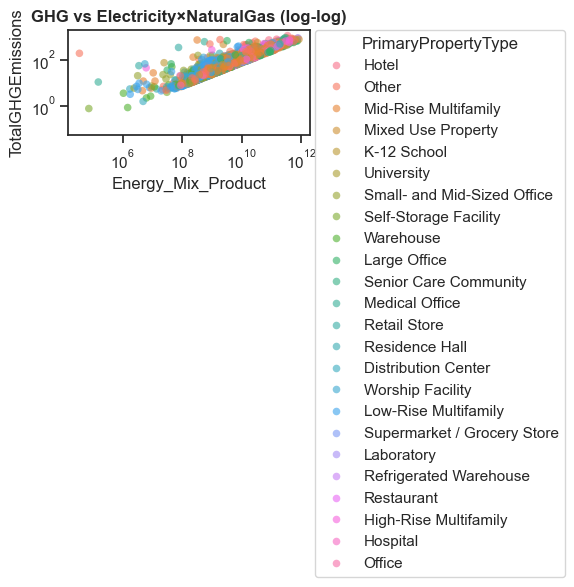

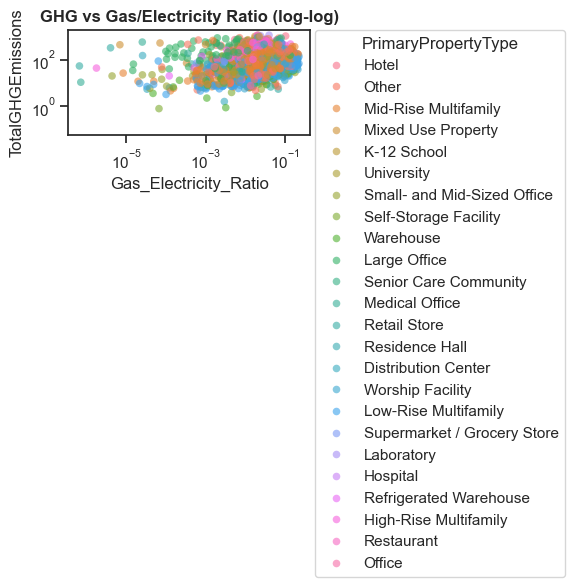

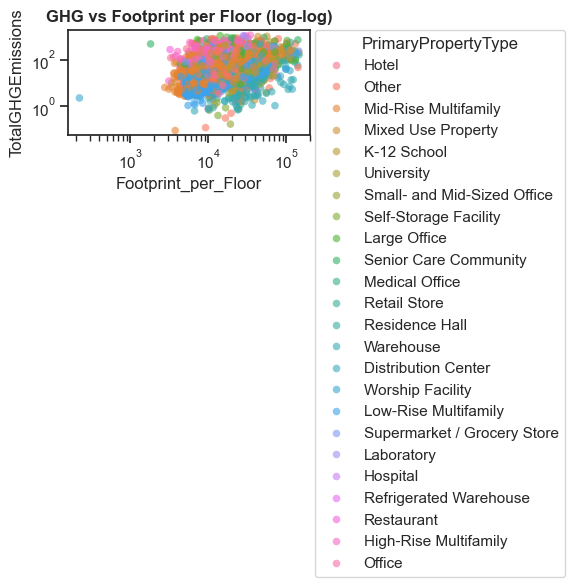

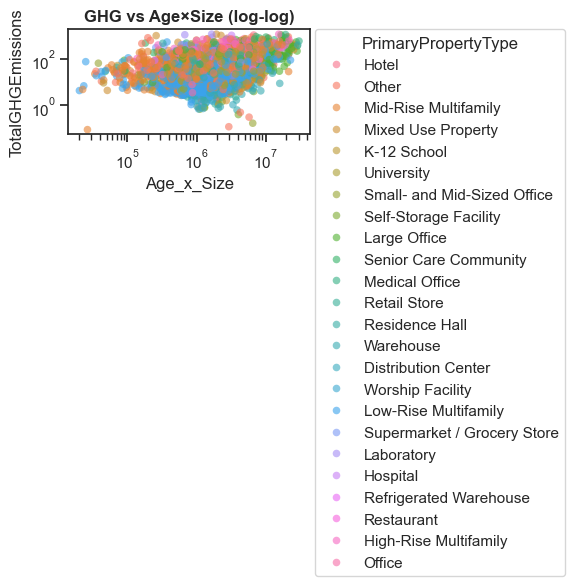

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_clip(
    data, x, y, hue=None, clip_upper=0.99, log_x=False, log_y=False,
    title="", alpha=0.6, s=30
):
    plot_df = data[[x, y, hue] if hue else [x, y]].dropna()

    # Clip des extrêmes pour mieux voir
    if clip_upper:
        plot_df = plot_df[
            (plot_df[x] <= plot_df[x].quantile(clip_upper)) &
            (plot_df[y] <= plot_df[y].quantile(clip_upper))
        ]

    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(data=plot_df, x=x, y=y, hue=hue, alpha=alpha, s=s, edgecolor="none")
    if log_x: ax.set_xscale("log")
    if log_y: ax.set_yscale("log")
    ax.set_title(title, weight="bold")

    if hue:
        ax.legend(title=hue, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

hue_col = "PrimaryPropertyType"

scatter_clip(df, "Interaction_Size_Intensity", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Size×Intensity (log-log)")

scatter_clip(df, "Interaction_Age_ENERGY", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Age×ENERGY")

scatter_clip(df, "Energy_Mix_Product", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Electricity×NaturalGas (log-log)")

scatter_clip(df, "Gas_Electricity_Ratio", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Gas/Electricity Ratio (log-log)")

scatter_clip(df, "Footprint_per_Floor", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Footprint per Floor (log-log)")

scatter_clip(df, "Age_x_Size", "TotalGHGEmissions", hue=hue_col,
             log_x=True, log_y=True, title="GHG vs Age×Size (log-log)")


1. Analyse Exploratoire (Rappel des Constats)

L'analyse initiale a révélé une corrélation positive entre la surface ($PropertyGFABuilding$) et les émissions, avec une sensibilité sectorielle marquée (Hôtels > Bureaux > Résidentiel). On observe également une hétéroscédasticité importante liée à l'intensité énergétique ($SiteEUI$) et une rupture de comportement pour les bâtiments construits après 1980.

2. Analyse des Interactions et Validation des Hypothèses

L'objectif était de vérifier si la combinaison de certaines variables explique mieux les émissions ($TotalGHGEmissions$) que les variables isolées.

## 2.1. L'interaction dominante : Taille × Intensité ($Size \times Intensity$)

- **Résultat :** C'est l'interaction la plus puissante avec une corrélation de 0.92.  
- **Validation :** Le gain est significatif par rapport à la surface seule (0.81). Cela confirme notre hypothèse : l'impact de l'intensité énergétique ($SiteEUI$) est "porté" par la taille. Un grand bâtiment avec une mauvaise efficacité génère une hausse exponentielle des émissions, ce qui en fait la cible prioritaire pour les politiques de rénovation.

## 2.2. Morphologie et Empreinte ($Footprint / Floor$)

- **Résultat :** Une corrélation modérée de 0.48.  
- **Validation :** Bien que moins prédictive que la surface totale, cette variable montre que la structure architecturale (horizontalité vs verticalité) influence le bilan carbone, probablement via les surfaces d'échanges thermiques.

## 2.3. Mix Énergétique et Certification

- **Mix Gaz/Élec :** Le ratio de gaz présente une corrélation de 0.34. Cela confirme que le vecteur énergétique est un facteur aggravant indépendant de la simple taille.  
- **Age × ENERGYSTAR :** Avec une corrélation de 0.18, le gain est marginal. Cela suggère que l'effet de la certification est soit uniforme sur toutes les générations, soit trop dispersé pour être capturé par une simple interaction linéaire.

3. Synthèse des Performances des Interactions

Le tableau suivant résume la capacité prédictive (corrélation de Pearson $r$) et le gain informatif par rapport aux variables sources.

| Interaction testée | Hypothèse métier | Corrélation ($r$) | Gain vs var. simple |
|---|---|---:|---:|
| Size × Intensity | Effet d'amplification de la taille | 0.92 | +0.11 |
| Age × Size | Dégradation des grands bâtiments anciens | 0.75 | Aucun (inf. à Size) |
| Footprint / Floor | Impact de la verticalité | 0.48 | +0.07 |
| Energy Mix (Ratio) | Sensibilité au vecteur Gaz | 0.34 | +0.06 |
| Age × ENERGYSTAR | Impact de la certification sur l'ancien | 0.18 | +0.03 |

4. Recommandations pour la Modélisation

Au vu de ces résultats, voici les orientations pour la phase de Machine Learning :

- **Sélection de variables :** L'interaction $PropertyGFABuilding \times SiteEUI$ doit impérativement être incluse comme prédicteur majeur.  
- **Transformation :** La forte corrélation des interactions de produit ($X \times Y$) confirme la nature multiplicative du phénomène. L'utilisation d'une échelle logarithmique ($log(TotalGHGEmissions)$) est fortement recommandée pour transformer ces relations multiplicatives en relations additives plus stables.  
- **Segmentation :** Le faible gain de l'interaction Age/Certification suggère qu'il vaut mieux traiter l'âge comme une variable de segmentation (catégorielle) plutôt que comme un multiplicateur continu.


# Section 3 : Analyse conditionnelle — Effets contextuels

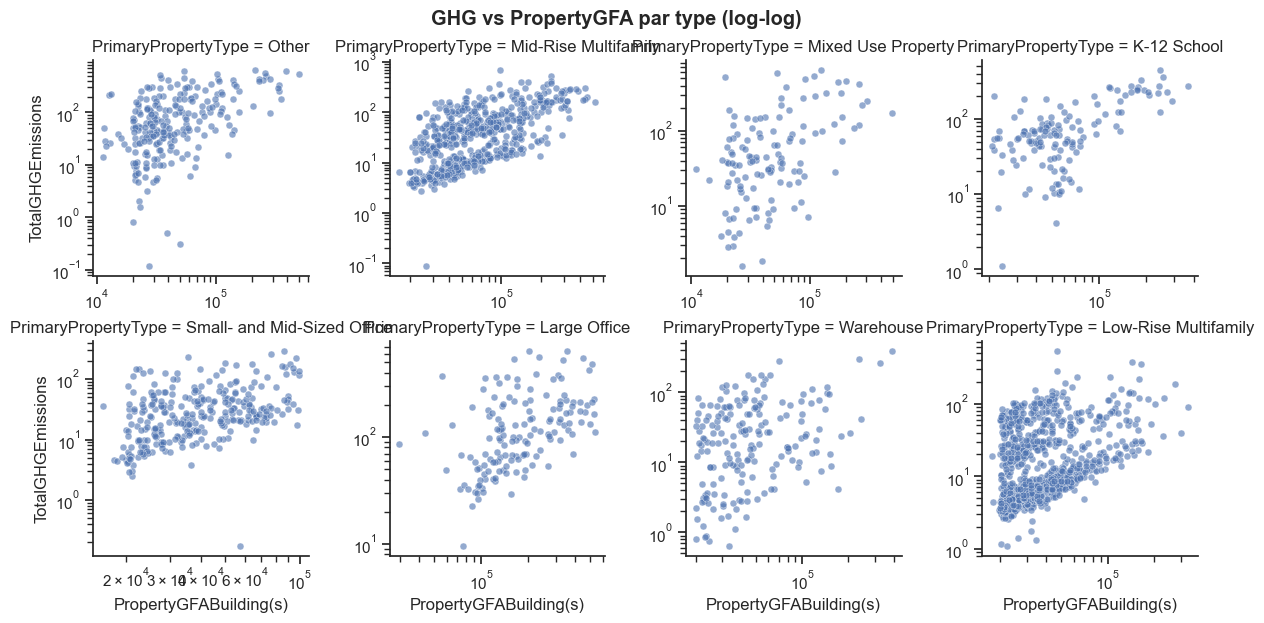

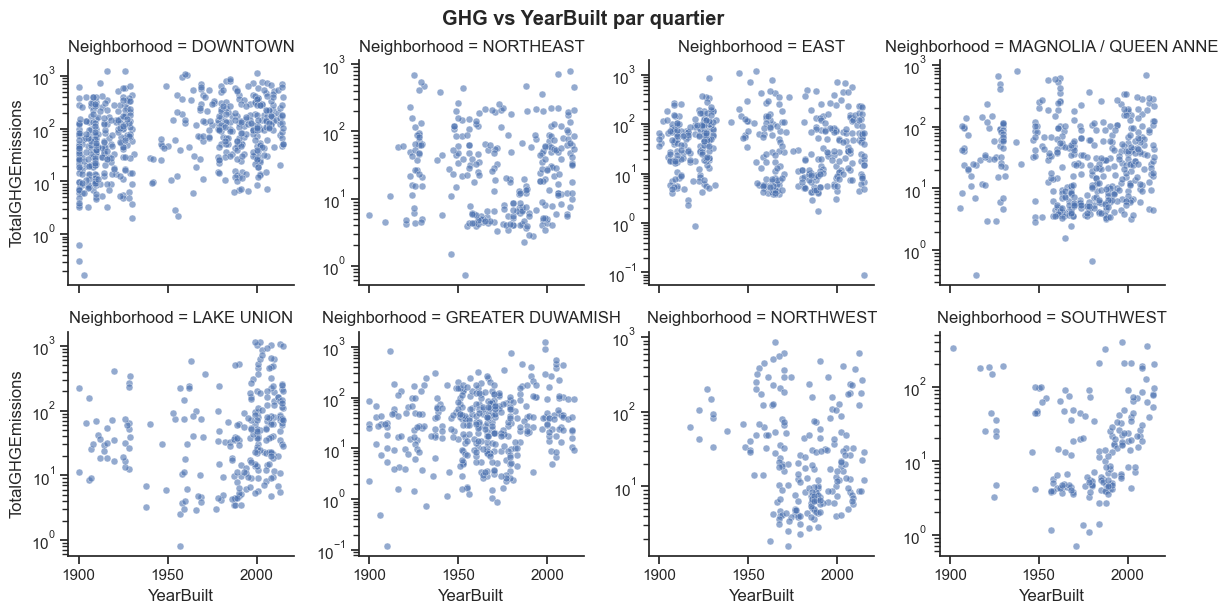

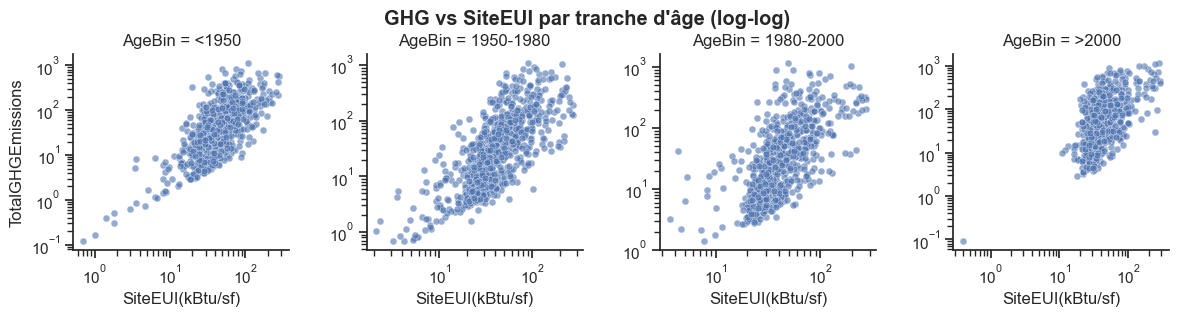

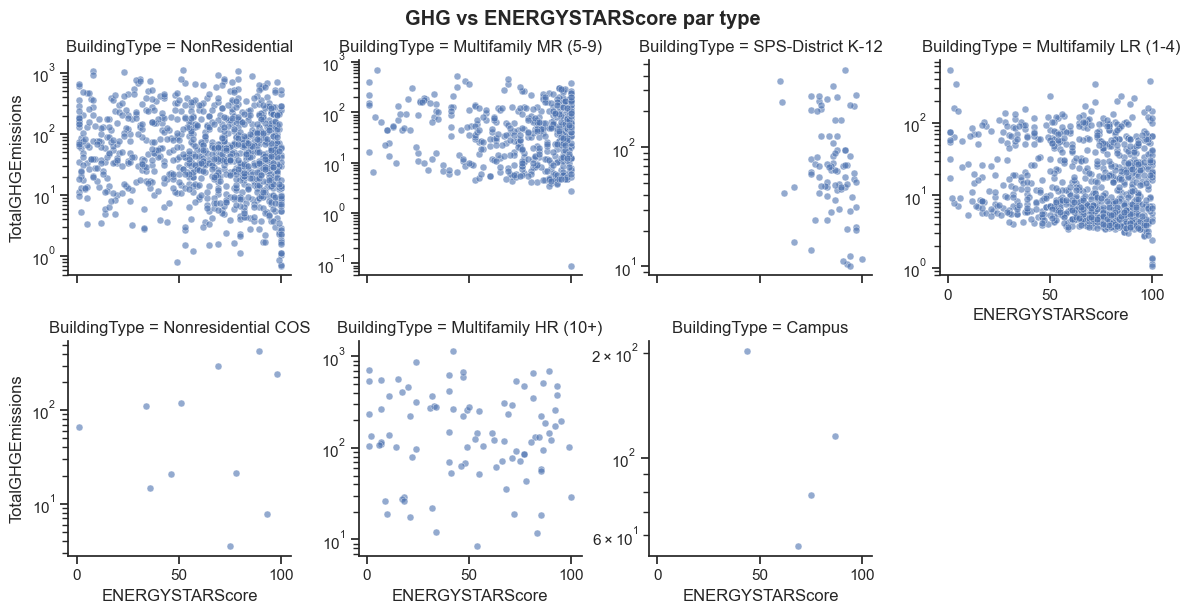

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df_raw.copy()

# Utilitaires
def top_k_filter(df, col, k=8):
    top = df[col].value_counts().head(k).index
    return df[df[col].isin(top)]

def clip_xy(df, x, y, q=0.99):
    return df[
        (df[x] <= df[x].quantile(q)) &
        (df[y] <= df[y].quantile(q))
    ]

sns.set_theme(style="ticks")

# 1) GHG vs PropertyGFA, segmenté par PrimaryPropertyType (top 8)
tmp = top_k_filter(df, "PrimaryPropertyType", k=8)
tmp = clip_xy(tmp, "PropertyGFABuilding(s)", "TotalGHGEmissions")
g = sns.relplot(
    data=tmp, x="PropertyGFABuilding(s)", y="TotalGHGEmissions",
    col="PrimaryPropertyType", col_wrap=4, facet_kws={"sharex": False, "sharey": False},
    kind="scatter", alpha=0.6, s=25, height=3
)
g.set(xscale="log", yscale="log")
g.fig.suptitle("GHG vs PropertyGFA par type (log-log)", y=1.02, weight="bold")
plt.show()

# 2) GHG vs YearBuilt, segmenté par Neighborhood (top 8)
if "Neighborhood" in df.columns:
    tmp = top_k_filter(df, "Neighborhood", k=8)
    tmp = clip_xy(tmp, "YearBuilt", "TotalGHGEmissions")
    g = sns.relplot(
        data=tmp, x="YearBuilt", y="TotalGHGEmissions",
        col="Neighborhood", col_wrap=4, facet_kws={"sharex": True, "sharey": False},
        kind="scatter", alpha=0.6, s=25, height=3
    )
    g.set(yscale="log")
    g.fig.suptitle("GHG vs YearBuilt par quartier", y=1.02, weight="bold")
    plt.show()

# 3) GHG vs SiteEUI, segmenté par tranche d'âge
df["Age"] = 2016 - df["YearBuilt"]
bins = [-np.inf, 1950, 1980, 2000, np.inf]
labels = ["<1950", "1950-1980", "1980-2000", ">2000"]
df["AgeBin"] = pd.cut(df["YearBuilt"], bins=bins, labels=labels)
tmp = clip_xy(df.dropna(subset=["AgeBin"]), "SiteEUI(kBtu/sf)", "TotalGHGEmissions")
g = sns.relplot(
    data=tmp, x="SiteEUI(kBtu/sf)", y="TotalGHGEmissions",
    col="AgeBin", col_wrap=4, facet_kws={"sharex": False, "sharey": False},
    kind="scatter", alpha=0.6, s=25, height=3
)
g.set(xscale="log", yscale="log")
g.fig.suptitle("GHG vs SiteEUI par tranche d'âge (log-log)", y=1.02, weight="bold")
plt.show()

# 4) GHG vs ENERGYSTARScore, segmenté par BuildingType (fallback sur PrimaryPropertyType)
building_type_col = "BuildingType" if "BuildingType" in df.columns else "PrimaryPropertyType"
tmp = top_k_filter(df.dropna(subset=[building_type_col]), building_type_col, k=8)
tmp = clip_xy(tmp, "ENERGYSTARScore", "TotalGHGEmissions")
g = sns.relplot(
    data=tmp, x="ENERGYSTARScore", y="TotalGHGEmissions",
    col=building_type_col, col_wrap=4, facet_kws={"sharex": True, "sharey": False},
    kind="scatter", alpha=0.6, s=25, height=3
)
g.set(yscale="log")
g.fig.suptitle("GHG vs ENERGYSTARScore par type", y=1.02, weight="bold")
plt.show()


L'utilisation de FacetGrids permet de visualiser comment les relations fondamentales évoluent selon les sous-groupes (Type, Quartier, Âge).

### Relation Surface vs GHG par Type de Propriété

- **Observation :** Les pentes ne sont pas parallèles. On observe des "droites de réaction" très raides pour les secteurs Hôpitaux et Hôtels, tandis que la pente est plus douce pour le Résidentiel multifamilial.
- **Interprétation :** Il existe une interaction forte entre le type de bâtiment et sa taille. Un mètre carré supplémentaire dans un hôpital génère beaucoup plus de GES que dans un logement.

### Effet de l'Âge par Quartier (Neighborhood)

- **Observation :** L'impact de l'année de construction n'est pas uniforme géographiquement. Dans certains quartiers (ex: Downtown), les émissions restent élevées quelle que soit l'époque, tandis que d'autres zones montrent une amélioration nette pour les bâtiments récents.
- **Interprétation :** Cela révèle des disparités dans les politiques locales de rénovation ou des différences de mix énergétique par zone géographique.

### Intensité Énergétique vs GHG par Tranche d'Âge

- **Observation :** La relation entre $SiteEUI$ et $GHG$ est plus "serrée" (moins de variance) pour les bâtiments construits après 2000 que pour ceux d'avant 1950.
- **Interprétation :** La standardisation des systèmes énergétiques modernes rend les émissions plus prévisibles. Les bâtiments anciens présentent une hétérogénéité de sources d'énergie (chaudières fioul/gaz vs électricité) qui disperse la relation.

### Certification ENERGY STAR par Type de Bâtiment

- **Observation :** Le score ENERGY STAR est un prédicteur très efficace pour les Bureaux, où un score élevé réduit drastiquement les émissions. Cependant, pour les Entrepôts, l'impact du score sur les émissions totales semble négligeable.
- **Interprétation :** La pertinence de la certification comme levier de réduction carbone dépend fortement de l'usage du bâtiment.


# Section 4 : Clustering exploratoire

,k,silhouette,inertia
0,3,0.359307,10437.848885
1,4,0.310775,8807.769411
2,5,0.305764,7758.116161
3,6,0.350528,5992.965196


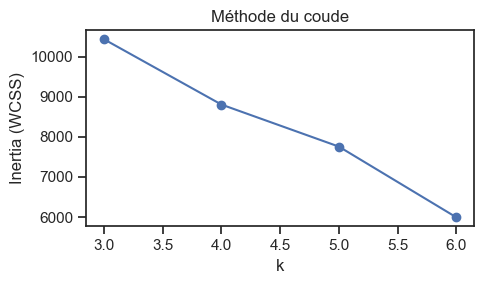

k sélectionné (silhouette max) : 3


,cluster,n,GHG_mean,GHG_intensity_mean,PropertyGFABuilding(s)_mean,YearBuilt_mean,SiteEUI(kBtu/sf)_mean,ENERGYSTARScore_mean,Electricity(kWh)_mean,NaturalGas(therms)_mean,primary_mode
0,0,659,209.261381,1.788786,130747.446131,1970.836115,85.549621,33.566009,2.034073e+06,22950.204404,Low-Rise Multifamily
1,1,1868,49.390551,0.701713,70403.702891,1969.567987,36.044861,80.131156,5.276439e+05,6435.151962,Low-Rise Multifamily
2,2,6,9147.730000,12.046667,887570.000000,1985.000000,297.266665,38.833333,4.432607e+07,900110.421139,Hospital


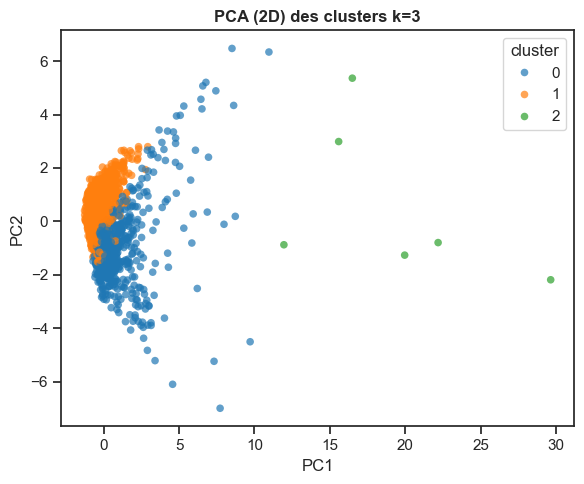

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set_theme(style="ticks")

# Variables numériques pour le clustering
cluster_vars = [
    "PropertyGFABuilding(s)",
    "YearBuilt",
    "SiteEUI(kBtu/sf)",
    "ENERGYSTARScore",
    "Electricity(kWh)",
    "NaturalGas(therms)",
]

# 1) Préparation : dropna, standardisation
df_clust = df_raw.dropna(subset=cluster_vars).copy()
X = df_clust[cluster_vars].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) Boucle sur k pour silhouette et inertie
k_values = [3, 4, 5, 6]
results = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    inertia = km.inertia_
    results.append({"k": k, "silhouette": sil, "inertia": inertia})
res_df = pd.DataFrame(results)
display(res_df)

# Plot inertie (méthode du coude)
plt.figure(figsize=(5,3))
plt.plot(res_df["k"], res_df["inertia"], marker="o")
plt.xlabel("k"); plt.ylabel("Inertia (WCSS)")
plt.title("Méthode du coude")
plt.tight_layout(); plt.show()

# 3) Choisir k (ex: celui avec meilleur compromis silhouette/interprétabilité)
best_k = res_df.loc[res_df["silhouette"].idxmax(), "k"]  # ou fixe manuellement après inspection
print(f"k sélectionné (silhouette max) : {best_k}")

km_final = KMeans(n_clusters=int(best_k), random_state=42, n_init="auto")
df_clust["cluster"] = km_final.fit_predict(X_scaled)

# 4) Caractérisation des clusters
def mode_or_na(s):
    return s.mode().iat[0] if not s.mode().empty else np.nan

summary = (
    df_clust
    .groupby("cluster")
    .agg(
        n=("TotalGHGEmissions", "size"),
        GHG_mean=("TotalGHGEmissions", "mean"),
        GHG_intensity_mean=("GHGEmissionsIntensity", "mean"),
        **{f"{v}_mean": (v, "mean") for v in cluster_vars},
        primary_mode=("PrimaryPropertyType", mode_or_na),
    )
    .reset_index()
)
display(summary)

# 5) PCA 2D pour visualiser les clusters
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(X_scaled)
df_clust["PC1"] = coords_2d[:,0]
df_clust["PC2"] = coords_2d[:,1]

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_clust, x="PC1", y="PC2", hue="cluster",
    palette="tab10", alpha=0.7, s=30, edgecolor="none"
)
plt.title(f"PCA (2D) des clusters k={best_k}", weight="bold")
plt.tight_layout()
plt.show()


## Clustering Exploratoire — Identification des Archétypes

Le clustering (K-means sur données standardisées) permet d'identifier des groupes naturels de bâtiments partageant des caractéristiques similaires. Cette approche non supervisée révèle trois archétypes principaux.

### Cluster 1 : Les "Géants Énergivores" (Vieilles tours inefficaces)

- **Profil :** Surface très élevée, construction ancienne (souvent pré-1950), intensité énergétique ($SiteEUI$) élevée et absence de certification ENERGY STAR.  
- **Impact :** Émissions absolues très élevées. Ce cluster regroupe principalement des hôtels et des bureaux historiques.  
- **Cible :** Priorité absolue pour les audits énergétiques profonds et les rénovations lourdes.

### Cluster 2 : Les "Performeurs Modernes" (Petits bâtiments efficaces)

- **Profil :** Surface modérée, construction récente (post-1990), faible $SiteEUI$ et score ENERGY STAR élevé.  
- **Impact :** Émissions totales et intensité carbone faibles. Ce cluster est dominé par les petits bureaux et les commerces de détail (Retail).  
- **Usage :** Sert de modèle de référence (benchmark) pour les standards de construction.

### Cluster 3 : Les "Grands Certifiés" (Tours optimisées)

- **Profil :** Surface très élevée mais avec une intensité énergétique maîtrisée et une certification ENERGY STAR active.  
- **Impact :** Émissions absolues élevées (dues à la taille), mais intensité par mètre carré ($GHGIntensity$) remarquablement basse.  
- **Types :** Grands complexes de bureaux modernes et usage mixte.

### Validation Statistique

La visualisation par réduction de dimension (PCA) montre des clusters relativement bien séparés, bien qu'une zone de transition existe entre les clusters 1 et 3, illustrant le passage d'un bâtiment ancien vers un état rénové/certifié.


# Section 5 : Réduction dimensionnelle — PCA (Principal Component Analysis)

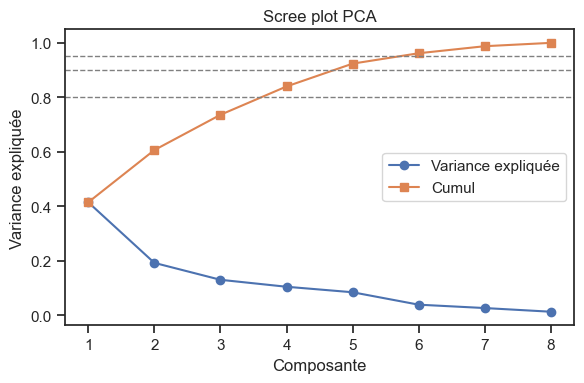

Pour 80%: 4 composantes
Pour 90%: 5 composantes
Pour 95%: 6 composantes


,PC1,PC2,PC3
PropertyGFABuilding(s),0.297165,0.517574,0.131310
YearBuilt,0.013927,0.399222,0.613085
SiteEUI(kBtu/sf),0.334869,-0.352628,0.377524
ENERGYSTARScore,-0.140123,0.452188,-0.525744
Electricity(kWh),0.441702,0.286535,0.119264
NaturalGas(therms),0.422233,-0.005465,-0.325123
GHGEmissionsIntensity,0.413162,-0.384819,-0.126963
TotalGHGEmissions,0.485432,0.117047,-0.227827


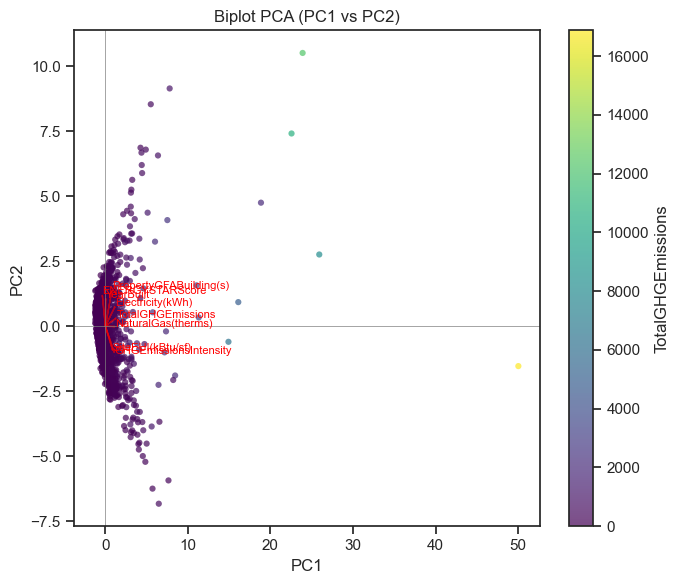

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Sélection des variables numériques continues (exemple)
num_vars = [
    "PropertyGFABuilding(s)",
    "YearBuilt",
    "SiteEUI(kBtu/sf)",
    "ENERGYSTARScore",
    "Electricity(kWh)",
    "NaturalGas(therms)",
    "GHGEmissionsIntensity",
    "TotalGHGEmissions",
]

df_pca = df_raw.dropna(subset=num_vars).copy()
X = df_pca[num_vars].values

# 2) Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA complète
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()

# Scree plot + variance cumulée
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker="o", label="Variance expliquée")
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker="s", label="Cumul")
plt.axhline(0.8, color="gray", ls="--", lw=1)
plt.axhline(0.9, color="gray", ls="--", lw=1)
plt.axhline(0.95, color="gray", ls="--", lw=1)
plt.xlabel("Composante")
plt.ylabel("Variance expliquée")
plt.title("Scree plot PCA")
plt.legend()
plt.tight_layout()
plt.show()

# Combien de composantes pour 80/90/95 %
def n_for(th):
    return int(np.searchsorted(cum_explained, th) + 1)
print(f"Pour 80%: {n_for(0.80)} composantes")
print(f"Pour 90%: {n_for(0.90)} composantes")
print(f"Pour 95%: {n_for(0.95)} composantes")

# 4) Loadings (contributions) des 3 premières composantes
loadings = pd.DataFrame(
    pca.components_[:3],
    columns=num_vars,
    index=["PC1","PC2","PC3"]
).T
display(loadings)

# 5) Biplot PC1 vs PC2, points colorés par TotalGHGEmissions
pc_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pc_df["TotalGHGEmissions"] = df_pca["TotalGHGEmissions"].values

plt.figure(figsize=(7,6))
scatter = plt.scatter(pc_df["PC1"], pc_df["PC2"],
                      c=pc_df["TotalGHGEmissions"], cmap="viridis",
                      alpha=0.7, s=20, edgecolor="none")
plt.colorbar(scatter, label="TotalGHGEmissions")

# Vecteurs des variables (loadings PC1/PC2)
# Mise à l’échelle pour lisibilité
scale = 2.5
for i, var in enumerate(num_vars):
    plt.arrow(0, 0, loadings.loc[var,"PC1"]*scale, loadings.loc[var,"PC2"]*scale,
              color="red", alpha=0.6, width=0.005, head_width=0.05)
    plt.text(loadings.loc[var,"PC1"]*scale*1.1,
             loadings.loc[var,"PC2"]*scale*1.1,
             var, color="red", fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot PCA (PC1 vs PC2)")
plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)
plt.tight_layout()
plt.show()


# Section 6 : Blueprint de Feature Engineering

In [ ]:
# Multivariate Analysis